In [2]:
import warnings
warnings.filterwarnings('ignore')

In [191]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
import re  
import nltk  
from sklearn.datasets import load_files  
#nltk.download('stopwords')  
from nltk.corpus import stopwords  
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering

# Precision Medicine

Detect relevant PubMed citations describing genetic mutations altering protein-protein interactions


Training datasets:

1. positive_training_abstracts.tsv
Positive training set of abstracts 

2. negative_training_abstracts.tsv
Negative training set of non-relevant abstracts 

In [4]:
# Read the data
data_positive = pd.read_csv('positive_training_abstracts.tsv', sep='\t', header=None)
data_negative = pd.read_csv('negative_training_abstracts.tsv', sep='\t', header=None)

In [5]:
# Abstracts are in the second colum of the dataframa
X_pos = data_positive[2]
X_neg = data_negative[2]

# We label positive publications with one and negative with 0
y_pos =  np.ones((len(X_pos),), dtype=int)
y_neg =  np.zeros((len(X_neg),), dtype=int)

# Create the data and labels arrays
X_init = np.append(X_pos,X_neg)
y = np.append(y_pos,y_neg)

# Pre-processing

In [7]:
def preprocessing(X):

    corpus = []

    stemmer = WordNetLemmatizer()

    for i in range(0, len(X)):  
        
        
        # Remove special characters
        doc = re.sub(r'\W', ' ', str(X[i]))
        
        # remove all single characters
        doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc)

        # Remove single characters from the start
        doc = re.sub(r'\^[a-zA-Z]\s+', ' ', doc) 

        # Substitute multiple spaces with single space
        doc = re.sub(r'\s+', ' ', doc, flags=re.I)

        # Lemmatization
        doc = doc.split()

        doc = [stemmer.lemmatize(word) for word in doc]
        doc = ' '.join(doc)

        corpus.append(doc)
    
    return corpus

In [8]:
# Before preprocessing
X_init[1]

'Store-operated Ca(2+) entry occurs through the binding of the endoplasmic reticulum (ER) Ca(2+) sensor STIM1 to Orai1, the pore-forming subunit of the Ca(2+) release-activated Ca(2+) (CRAC) channel. Although the essential steps leading to channel opening have been described, fundamental questions remain, including the functional stoichiometry of the CRAC channel. The crystal structure of Drosophila Orai indicates a hexameric stoichiometry, while studies of linked Orai1 concatemers and single-molecule photobleaching suggest that channels assemble as tetramers. We assessed CRAC channel stoichiometry by expressing hexameric concatemers of human Orai1 and comparing in detail their ionic currents to those of native CRAC channels and channels generated from monomeric Orai1 constructs. Cell surface biotinylation results indicated that Orai1 channels in the plasma membrane were assembled from intact hexameric polypeptides and not from truncated protein products. In addition, the L273D mutatio

In [79]:
corpus = preprocessing(X_init)

In [10]:
# After preprocessing
corpus[1]

'Store operated Ca 2 entry occurs through the binding of the endoplasmic reticulum ER Ca 2 sensor STIM1 to Orai1 the pore forming subunit of the Ca 2 release activated Ca 2 CRAC channel Although the essential step leading to channel opening have been described fundamental question remain including the functional stoichiometry of the CRAC channel The crystal structure of Drosophila Orai indicates hexameric stoichiometry while study of linked Orai1 concatemers and single molecule photobleaching suggest that channel assemble a tetramers We assessed CRAC channel stoichiometry by expressing hexameric concatemers of human Orai1 and comparing in detail their ionic current to those of native CRAC channel and channel generated from monomeric Orai1 construct Cell surface biotinylation result indicated that Orai1 channel in the plasma membrane were assembled from intact hexameric polypeptide and not from truncated protein product In addition the L273D mutation depressed channel activity equally r

# Selection of parameters

In [ ]:
# First of all, we will try different numbers of selected features to identify the number that 
# maximizes the accuracy of a simple classifier as Gaussian Naive Bayes

In [145]:
# Convert corpus of documents to a matrix of words
# Scale down the impact of tokens that occur very frequently in the corpus 

# By default it converts to lowercase and uses l2 norm (cosine)
def tfidf(documents,maxfeat=None,mindf=5,maxdf=0.7,nrm='l2'):
    tfidfconverter = TfidfVectorizer(max_features=maxfeat, 
                                 min_df=mindf, max_df=maxdf, # Frequent and rare words removal
                                 stop_words=stopwords.words('english'),norm=nrm)  # Remove stopwords 
    X = tfidfconverter.fit_transform(documents).toarray()  
    return X

In [146]:
nfeat = [100,500,700,800,900,1000,1500,5000,None]

In [147]:
accuracy = []
for i in range (0,len(nfeat)):
    X = tfidf(documents = corpus, maxfeat=nfeat[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    classifier = GaussianNB()
    classifier.fit(X_train,y_train)
    accuracy.append(classifier.score(X_test, y_test))
    

In [148]:
print(accuracy)

[0.9283088235294118, 0.9430147058823529, 0.9442401960784313, 0.9442401960784313, 0.9424019607843137, 0.9381127450980392, 0.9375, 0.9307598039215687, 0.9215686274509803]


Text(0, 0.5, 'GaussianNB accuracy')

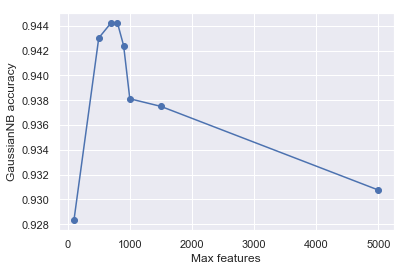

In [149]:
plt.plot(nfeat, accuracy, marker='o')
plt.xlabel('Max features')
plt.ylabel('GaussianNB accuracy')

We will use a maximum number of features of 700 as a trade-off between performance and complexity.

Using l2 or l1 norm didn't make any difference in the results. 

In [151]:
best_n_feat = 700

We will evaluate the impact of max_df and min_df for the performance of the GaussianNB classifier

max_df is used for removing terms that appear too frequently. i.e.

max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
Thus, the default setting does not ignore any terms.

min_df is used for removing terms that appear too infrequently. i.e.

min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". 


In [161]:
# We will try different combinations of these values
maxdf_test = [0.25, 0.5, 0.75]
mindf_test = [1, 5, 10]
accuracy = np.zeros((len(maxdf_test), len(mindf_test)))
for i in range (0,len(maxdf_test)):
    for j in range (0,len(mindf_test)):
        X = tfidf(documents = corpus, maxfeat=best_n_feat, mindf=mindf_test[j],maxdf=maxdf_test[i])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        classifier = GaussianNB()
        classifier.fit(X_train,y_train)
        accuracy[i][j] = classifier.score(X_test, y_test)

In [162]:
print(accuracy)

[[0.94362745 0.94362745 0.94362745]
 [0.9442402  0.94485294 0.9442402 ]
 [0.94485294 0.9442402  0.9442402 ]]


In [167]:
# The impact is not very significative, but we will pick up the values
# that procude a better accuracy score for the GaussianNB classifier
best_maxdf = 0.75
best_mindf = 5
X = tfidf(documents = corpus, maxfeat=best_n_feat, mindf=best_mindf,maxdf=best_maxdf)

# Classification

In [168]:
# Split the data in train and test
# By default this method shuffles the data and stratifies the train and test partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [169]:
#Naive Bayes
classifier = GaussianNB()
classifier.fit(X_train,y_train)
print('Score of Gaussian NB in test : %.3f' % classifier.score(X_test, y_test))

Score of Gaussian NB in test : 0.944


In [177]:
# Random Forest

classifier = RandomForestClassifier(n_estimators=1000, random_state=0)  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)  
print('Score of RF in test : %.3f' % classifier.score(X_test, y_test))

Score of RF in test : 0.961


In [173]:
# Support Vector Machines with grid search for hyperparameter selection

parameters = {'kernel':('linear', 'rbf'), 
              'C':(1,0.5)}
classifier = GridSearchCV(SVC(), param_grid=parameters,cv=5)
classifier.fit(X_train,y_train)
print('Score of SVM in test : %.3f' % classifier.score(X_test, y_test))

Score of SVM in test : 0.971


In [176]:
print(classifier.best_params_)

{'C': 0.5, 'kernel': 'linear'}


- Which tips can you give about constructing an automatic text classifier? What do you recommend to do? What do you recommend not to do?
- What is the best classifier you have obtained?

# Clustering

In [39]:
# Standarization and PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(X)

# define the PCA algorithm with the maximum number of parameters,
# and fit PCA algorithm to the data
X_pca = PCA().fit(X_std)

# obtain the minimum number of components needed to retain 99% of variance 
var_ratio = X_pca.explained_variance_ratio_
variance = 0.99
X_cumsum_var_ratio = np.cumsum(var_ratio)
n_components = np.where(X_cumsum_var_ratio >= variance)[0][0] + 1
print('\nNumber of components that explain 99% of variance:', n_components)
print('Total variance explained (%) by these components:', X_cumsum_var_ratio[n_components-1]*100)

# Project data into the PCA
X_pca = X_pca.transform(X_std)[:, :n_components]


Number of components that explain 99% of variance: 1443
Total variance explained (%) by these components: 99.00719233603871


In [52]:
# Standarization and PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_pca = StandardScaler().fit_transform(X)

# define the PCA algorithm with the maximum number of parameters,
# and fit PCA algorithm to the data
#X_pca = PCA().fit(X_std)
#X_pca = PCA(n_components=5).fit_transform(X_std)

In [178]:
from sklearn.cluster import KMeans

# number of clusters: 2 (we know from the original data that there are 2 classes: Positive and Negative)

# k-means
kmeans = KMeans(n_clusters=2,
                init='random', # random or kmeans++ (more efficient)
                n_init=10,  # number of repetitions (to avoid local minima)
                max_iter=500,
                random_state=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [183]:
def results_clustering(y_true,y_pred,labels):

    for i in np.unique(labels):
        
        inds = (np.where(np.array(labels) == i))[0]
        print('\033[1m'+'- Cluster %d' % i + '\033[0m')
        print('  %g%% of total patterns' % (100*len(inds)/len(labels)))
    
    matches = np.sum(y_true == y_pred)
    print('Clustering algorithm was correct',  matches , 'out of', y_true.shape[0], 
      '(' + str(round(matches/y_true.shape[0]*100, 1)) + '%)')

In [184]:
results_clustering(y,y_kmeans,kmeans.labels_)

- Cluster 0
  45.3409% of total patterns
- Cluster 1
  54.6591% of total patterns
Clustering algorithm was correct 7714 out of 8156 (94.6%)


In [ ]:
# Visualize the results on PCA-reduced data?

- Which tips can you give about constructing a text clustering with k-means? What do you recommend to do? What do you recommend not to do?
- What is the best clustering you have obtained? The quality of the cluster is the degree of correspondence between real class and assigned cluster. For example:
o If there are 2 clusters and cluster 0 contains all examples of positive class and cluster 1 contains all examples of negative class, the clustering is perfect.
o If there are 2 clusters and cluster 1 contains all examples of positive class and cluster 0 contains all examples of negative class, the clustering is also perfect.
o If there are 2 clusters and cluster 0 contains 50% of examples of positive class and 50% of examples of negative class, and statistics in cluster 1 are similar, the clustering quality is the worst possible.

# Clustering 5 clases

In [185]:
# Read the data
data_AE = pd.read_csv('Alzheimer_abstracts.tsv', sep='\t', header=None)
data_bladder = pd.read_csv('Bladder_Cancer_abstracts.tsv', sep='\t', header=None)
data_breast = pd.read_csv('Breast_Cancer_abstracts.tsv', sep='\t', header=None)
data_cervical = pd.read_csv('Cervical_Cancer_abstracts.tsv', sep='\t', header=None)
data_neg = pd.read_csv('negative_abstracts.tsv', sep='\t', header=None)

In [196]:
# Abstracts are in the second colum of the dataframe
X_AE= data_AE[2]
X_bladder= data_bladder[2]
X_breast= data_breast[2]
X_cervical = data_cervical[2]
#X_neg = data_negative[2]

# We label the publications with a number
#y_neg =  np.zeros((len(X_neg),), dtype=int)
y_AE =  np.ones((len(X_AE),), dtype=int)
y_bladder =  np.ones((len(X_bladder),), dtype=int)*2
y_breast =  np.ones((len(X_breast),), dtype=int)*3
y_cervical =  np.ones((len(X_cervical),), dtype=int)*4

# Create the data and labels arrays
X_init = np.concatenate((X_AE, X_bladder, X_breast, X_cervical), axis=None)
y = np.concatenate((y_AE, y_bladder, y_breast, y_cervical), axis=None)

In [197]:
corpus = preprocessing(X_init)

In [198]:
# Convert corpus of documents to a matrix of words
# Scale down the impact of tokens that occur very frequently in the corpus 

# By default it converts to lowercase and uses l2 norm (cosine)
tfidfconverter = TfidfVectorizer(max_features=5000, 
                                 min_df=5, max_df=0.7, # Frequent and rare words removal
                                 stop_words=stopwords.words('english'))  # Remove stopwords 
X = tfidfconverter.fit_transform(corpus).toarray() 

In [199]:
# Split the data in train and test
# By default this method shuffles the data and stratifies the train and test partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [200]:


#check covariance types
#parameters = {'covariance_type': ('spherical', 'tied', 'diag', 'full')}
#construct grid search object that uses 5 fold cross validation
#classifier = GridSearchCV(GMM(n_components=5),parameters,cv=5)
#fit the data
gmm = GMM(n_components=4)
gmm.fit(X_train)
#plot the number of Gaussians against their rank
#plt.scatter(clf.cv_results_['param_covariance_type'],\
#            clf.cv_results_['rank_test_score'])
y_gmm = gmm.predict(X)
results_clustering(y,y_gmm,[1,2,3,4])

- Cluster 0
  20% of total patterns
- Cluster 1
  20% of total patterns
- Cluster 2
  20% of total patterns
- Cluster 3
  20% of total patterns
- Cluster 4
  20% of total patterns
Clustering algorithm was correct 533 out of 4000 (13.3%)


In [ ]:
results_clustering(y,y_gmm,[1,2,3,4])

In [ ]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(X)  
results_clustering(y,y_gmm,[1,2,3,4])